# 3. Classifier Models - Hold2Vec Embeddings & MLP Classifier

In [34]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import random

import sys
sys.path.append('..')

from data_loading import *
from embeddings.hold2vec import *
from embeddings.route_embeddings import *
from embeddings.embedding_helpers import *
from visualization import plot_route_from_df, plot_classifiers_certainty

## MLP with Hold2Vec Embeddings

### Loading the Data

In [6]:
df = load_dataframe('../data/2017.json')
df = add_font_scale(df)
df = add_v_grade(df)
# df = df[df.v_grade < 7]
df.head()

,font_scale,user_rating,holds,font_scale_int,v_grade,v_grade_int
0,6A+,1,"[H5, E7, F8, D10, E13, C14, C16, B18, E18, F9,...",1,V3,0
1,6A+,2,"[H5, E7, D8, D10, E13, C14, C16, B18, E18]",1,V3,0
2,6B+,2,"[A4, B4, C7, D9, F12, D15, F18]",3,V4,1
3,6A+,2,"[K4, J4, I7, H9, I10, F12, F13, E6, B14, C16, ...",1,V3,0
4,6B+,2,"[G8, D9, F12, C13, F15, D17, F18, E6, G4, F4]",3,V4,1


### Building Embeddings

In [170]:
filename = 'hold2vec_skip-gram_embedding100_window8_epochs20.npy'

hold_embeddings_matrix = load_hold_matrix(filename = '../data/embeddings/' + filename)
hold_embeddings_matrix = hold_embeddings_matrix.T

weights = tf_idf_weights_old(df.holds)
embeddings = 1 * pooled_embedding(df.holds, hold_embeddings=hold_embeddings_matrix, pool_method='sum', weights=weights)

#weights = tf_idf_weights(df.holds)
#embeddings = 10_000_000 * pooled_embedding(df.holds, hold_embeddings=hold_embeddings_matrix, pool_method='sum', weights=weights)

### Train / Test Split

In [171]:
y = np.array(df.v_grade_int)
X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2, random_state=42, stratify=y)
#X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15092, 100) (15092,)
(3773, 100) (3773,)


### Training the MLP Classifier

In [226]:
#classifier = MLPClassifier(random_state=42, max_iter=300, hidden_layer_sizes=(20,15,), solver='lbfgs', alpha=0.00015)
classifier = MLPClassifier(random_state=42, max_iter=300, hidden_layer_sizes=(20,15,), solver='adam', alpha=0.00015)
classifier.fit(X_train, y_train)

/Users/benjaminglaus/miniconda3/envs/data/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.00015, hidden_layer_sizes=(20, 15), max_iter=300,
              random_state=42)

### Report: Classification of Training Data

In [227]:
y_train_pred = classifier.predict(X_train)

sk_report_train = classification_report(
    digits=4,
    y_true= y_train, 
    y_pred= y_train_pred
)
print(sk_report_train)

print("Confusion Matrix")
for a in confusion_matrix(y_train, y_train_pred):
    for b in a:
        print(f'{b:4d}', end=' ')
    print()

              precision    recall  f1-score   support

           0     0.7105    0.7643    0.7364      4918
           1     0.4186    0.3505    0.3815      3310
           2     0.4310    0.6400    0.5151      3814
           3     0.3333    0.0136    0.0262      1174
           4     0.0000    0.0000    0.0000       474
           5     0.3956    0.4652    0.4276      1120
           6     1.0000    0.0105    0.0208       190
           7     0.0000    0.0000    0.0000        60
           8     0.0000    0.0000    0.0000        18
           9     0.0000    0.0000    0.0000         5
          10     0.0000    0.0000    0.0000         9

    accuracy                         0.5234     15092
   macro avg     0.2990    0.2040    0.1916     15092
weighted avg     0.5001    0.5234    0.4879     15092

Confusion Matrix
3759  741  403    1    0   14    0    0    0    0    0 
1084 1160 1040    2    0   24    0    0    0    0    0 
 402  761 2441   15    0  195    0    0    0    0    0 
  

/Users/benjaminglaus/miniconda3/envs/data/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminglaus/miniconda3/envs/data/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminglaus/miniconda3/envs/data/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

### Report: Classification of Validation Data

In [228]:
y_test_pred = classifier.predict(X_test)

sk_report_test = classification_report(
    digits=4,
    y_true= y_test, 
    y_pred= y_test_pred
)
print(sk_report_test)
matrix = confusion_matrix(y_test, y_test_pred, normalize='true')

print("Confusion Matrix")
for a in confusion_matrix(y_test, y_test_pred):
    for b in a:
        print(f'{b:4d}', end=' ')
    print()

              precision    recall  f1-score   support

           0     0.6976    0.7282    0.7126      1229
           1     0.3629    0.3120    0.3355       827
           2     0.4167    0.6237    0.4996       954
           3     0.0000    0.0000    0.0000       294
           4     0.0000    0.0000    0.0000       119
           5     0.3500    0.4250    0.3839       280
           6     0.0000    0.0000    0.0000        48
           7     0.0000    0.0000    0.0000        15
           8     0.0000    0.0000    0.0000         4
           9     0.0000    0.0000    0.0000         1
          10     0.0000    0.0000    0.0000         2

    accuracy                         0.4948      3773
   macro avg     0.1661    0.1899    0.1756      3773
weighted avg     0.4381    0.4948    0.4605      3773

Confusion Matrix
 895  224  103    0    0    7    0    0    0    0    0 
 282  258  274    2    0   11    0    0    0    0    0 
  95  195  595    3    0   65    1    0    0    0    0 
  

/Users/benjaminglaus/miniconda3/envs/data/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminglaus/miniconda3/envs/data/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminglaus/miniconda3/envs/data/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

7811
['F3', 'C5', 'E9', 'I10', 'I11', 'K13', 'G16', 'G18']
    V3 0.73%
    V4 4.21%
    V5 33.33%
    V6 23.82%
    V7 11.82%
>   V8 23.76%
    V9 1.62%
   V10 0.25%
   V11 0.15%
   V12 0.03%
   V13 0.28%


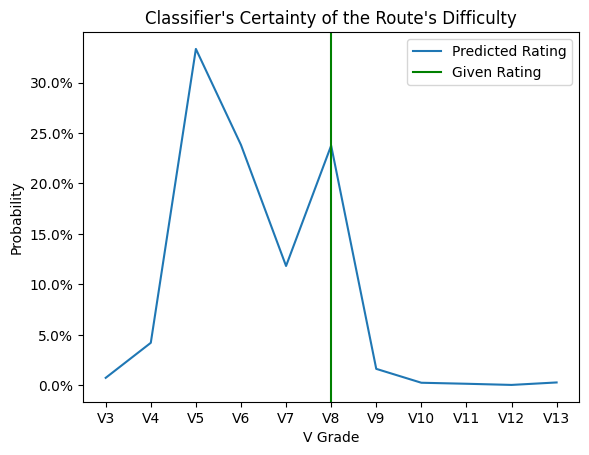

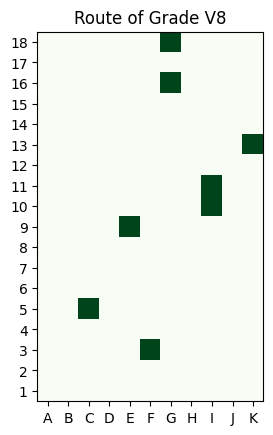

In [239]:
# predict probabilities of grades for route at index route_i
route_i = random.choice(list(df.index)) # choose a random route (harder then)
print(route_i)

route = df.holds[route_i]
embedded_route = pooled_embedding([route], hold_embeddings=hold_embeddings_matrix, pool_method='sum', weights=weights)

y_true = df.v_grade_int[route_i]
y_probas = classifier.predict_proba(embedded_route)

# print the route
print(route)

# print out the probabilities
n = len(y_probas[0])
int_to_V_grade = {v: k for k, v in V_GRADE.items()}

for i in range(n):
    print('> ' if i == y_true else '  ', end='')
    print(f'{int_to_V_grade[i]:>4} {y_probas[0][i]*100:.2f}%')
    
plot_classifiers_certainty(y_true, y_probas, show_full_y_axis=False)
plot_route_from_df(df, route_i, scale='v_grade')